<a href="https://colab.research.google.com/github/RibhuAgarwal/StockAnalyzer/blob/main/Stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter stock ticker symbol (e.g., AAPL, TSLA): DIS


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0292
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0025
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0020
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0020
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0017
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0017
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0013
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0013
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0013
Epoch 10/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0013
Epoch 11/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0013
Epoch 12/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0011
Epoch 13/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 9.6562e-04
Epoch 14/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0010
Epoch 15/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0012

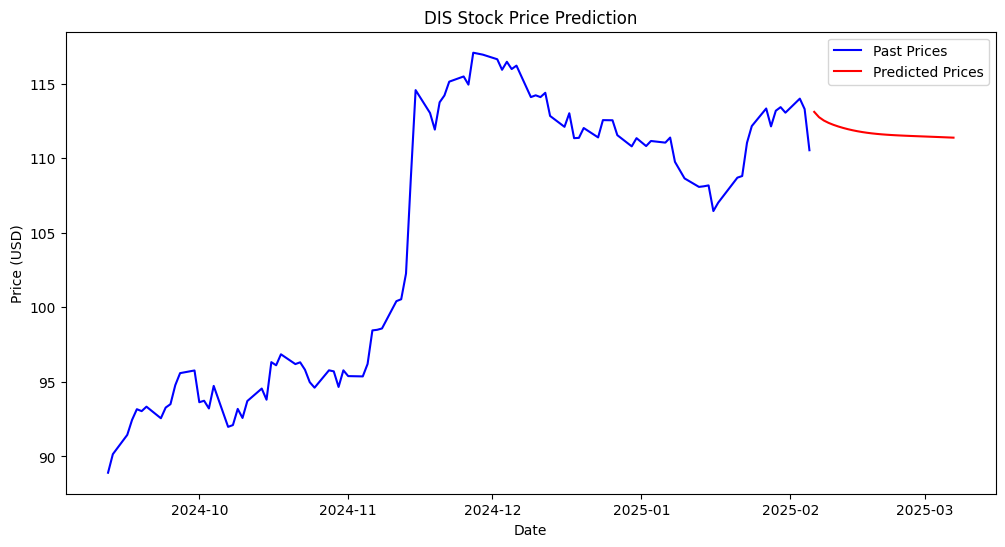

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def get_stock_data(ticker, start_date="2015-01-01"):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date)
    return df[['Close']]

def prepare_data(data, time_steps=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(time_steps, len(data_scaled)):
        X.append(data_scaled[i-time_steps:i, 0])
        y.append(data_scaled[i, 0])

    return np.array(X), np.array(y), scaler

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def predict_future(model, data, scaler, days=30):
    """Predict future stock prices using the trained LSTM model."""
    prediction_list = list(data[-60:].flatten())  # Ensure it's a flat list of numbers

    for _ in range(days):
        x_input = np.array(prediction_list[-60:]).reshape(1, 60, 1)  # Reshape for LSTM input
        prediction = model.predict(x_input, verbose=0)
        prediction_list.append(float(prediction[0][0]))  # Ensure it's a scalar float

    return scaler.inverse_transform(np.array(prediction_list[-days:]).reshape(-1, 1))


if __name__ == "__main__":
    stock_name = input("Enter stock ticker symbol (e.g., AAPL, TSLA): ")
    df = get_stock_data(stock_name)

    X, y, scaler = prepare_data(df.values)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = build_lstm_model((X.shape[1], 1))
    model.fit(X, y, epochs=20, batch_size=32)

    future_30_days = predict_future(model, scaler.transform(df.values), scaler, 30)

    # Plot Results
    plt.figure(figsize=(12,6))
    plt.plot(df.index[-100:], df['Close'].values[-100:], label='Past Prices', color='blue')
    future_dates = pd.date_range(start=df.index[-1], periods=31)[1:]
    plt.plot(future_dates, future_30_days, label='Predicted Prices', color='red')
    plt.title(f"{stock_name} Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet  # Corrected import
from sklearn.model_selection import train_test_split

def get_stock_data(ticker, start_date="2000-01-01"):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date)
    return df[['Close']]

def prepare_data(data, time_steps=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(time_steps, len(data_scaled)):
        X.append(data_scaled[i-time_steps:i, 0])
        y.append(data_scaled[i, 0])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), scaler

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=100, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(units=100, return_sequences=False),
        Dropout(0.3),
        Dense(units=50),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def predict_arima(data, days=30):
    model = ARIMA(data, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=days)
    return forecast

def predict_prophet(data, days=30):
    df = pd.DataFrame({'ds': data.index, 'y': data['Close']})
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=days)
    forecast = model.predict(future)
    return forecast[['ds', 'yhat']].tail(days)

def predict_hybrid(model, data, scaler, days=30):
    lstm_preds = predict_future(model, data, scaler, days)
    arima_preds = predict_arima(data, days)
    prophet_preds = predict_prophet(data, days)

    hybrid_preds = (lstm_preds.flatten() + arima_preds.values + prophet_preds['yhat'].values) / 3
    return hybrid_preds

def analyze_stock_news(ticker):
    url = f'https://news.google.com/search?q={ticker}+stock&hl=en-US&gl=US&ceid=US:en'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    headlines = [h.text for h in soup.find_all('a', class_='DY5T1d')][:10]

    polarity = 0
    for headline in headlines:
        analysis = TextBlob(headline)
        polarity += analysis.sentiment.polarity

    avg_polarity = polarity / len(headlines) if headlines else 0
    sentiment = "Neutral"
    if avg_polarity > 0.1:
        sentiment = "Positive"
    elif avg_polarity < -0.1:
        sentiment = "Negative"

    return sentiment, headlines

if __name__ == "__main__":
    stock_name = input("Enter stock ticker symbol (e.g., AAPL, TSLA): ").upper()
    prediction_days = int(input("Enter the number of days you want to predict: "))
    df = get_stock_data(stock_name)

    X_train, X_test, y_train, y_test, scaler = prepare_data(df.values)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

    hybrid_predictions = predict_hybrid(model, scaler.transform(df.values), scaler, prediction_days)

    shares_owned = int(input("How many shares do you own? "))
    purchase_price = float(input("At what price did you buy them? "))

    predicted_price = hybrid_predictions[-1]
    total_value = shares_owned * predicted_price
    investment_value = shares_owned * purchase_price

    recommendation = "Hold"
    if predicted_price > purchase_price * 1.05:
        recommendation = "Sell"
    elif predicted_price < purchase_price * 0.95:
        recommendation = "Buy"

    sentiment, news_headlines = analyze_stock_news(stock_name)

    print(f"Predicted price in {prediction_days} days: ${predicted_price:.2f}")
    print(f"Your total portfolio value at predicted price: ${total_value:.2f}")
    print(f"Recommendation: {recommendation}")
    print(f"News Sentiment Analysis: {sentiment}")
    print("Latest News Headlines:")
    for news in news_headlines:
        print(f"- {news}")

    # Plot Results
    plt.figure(figsize=(12,6))
    plt.plot(df.index[-100:], df['Close'].values[-100:], label='Past Prices', color='blue')
    future_dates = pd.date_range(start=df.index[-1], periods=prediction_days+1)[1:]
    plt.plot(future_dates, hybrid_predictions, label=f'Hybrid Predicted Prices ({prediction_days} days)', color='purple')
    plt.title(f"{stock_name} Stock Price Prediction (Hybrid Model)")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.show()


Enter stock ticker symbol (e.g., AAPL, TSLA): td.to
Enter the number of days you want to predict: 60
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - loss: 3.5606e-04 - val_loss: 0.0031
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - loss: 4.0252e-04 - val_loss: 0.0018
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - loss: 3.9411e-04 - val_loss: 0.0014
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - loss: 3.5512e-04 - val_loss: 4.4986e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 143ms/step - loss: 3.1063e-04 - val_loss: 0.0029
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - loss: 4.6982e-04 - val_loss: 3.6521e-04
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 3.1887e-04 - val_loss: 4.1658e-04
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - loss: 2.9933e-04 - val_loss: 8.6478e-04
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - loss: 3.1537e-04 - val_loss: 9.9269e-04
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 3.0203e-04

AttributeError: 'numpy.ndarray' object has no attribute 'index'